In [1]:
import os
os.chdir("../")

In [2]:
import numpy as np 
from rmsKit.utils import *
from rmsKit.lattice import *
import pandas
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [3]:
IMAGE_PATH = Path("visualize/image")
WORM_RESULT_PATH = Path("../output_worm/zetta")
MODEL_NAME = "HXYZ1D"
N = 1000000
BETA_THRES = 20
if not IMAGE_PATH.exists():
    raise FileNotFoundError("{} does not exist.".format(IMAGE_PATH.resolve()))
if not WORM_RESULT_PATH.exists():
    raise FileNotFoundError("{} does not exist.".format(WORM_RESULT_PATH.resolve()))

image_model_dir = IMAGE_PATH / MODEL_NAME
worm_result_path = WORM_RESULT_PATH / MODEL_NAME


In [146]:
image_model_dir = IMAGE_PATH / MODEL_NAME
worm_result_path = WORM_RESULT_PATH / MODEL_NAME

print("looking for the result in {}".format(worm_result_path.resolve()))
print(worm_result_path.resolve())
df = result_to_dataframe(worm_result_path.resolve().as_posix())
df = df[df.sweeps == N]

df = df[df["temperature"] >= 1 / BETA_THRES]
print("temeprature simulated: {}".format(np.sort(df.temperature.unique())))
print("L simulated: {}".format(np.sort(df.n_sites.unique())))

params_df = param_dict_normalize(df['ham_path'].apply(extract_parameters_from_path))
df_final = pd.concat([df, params_df], axis=1)

looking for the result in /Users/keisukemurota/Documents/todo/worms/output_worm/zetta/HXYZ1D
/Users/keisukemurota/Documents/todo/worms/output_worm/zetta/HXYZ1D
temeprature simulated: [0.25 1.  ]
L simulated: [10 11 15]


In [197]:
df_final.temperature.unique(), df_final.n_sites.unique()

(array([1.  , 0.25]), array([10, 11, 15]))

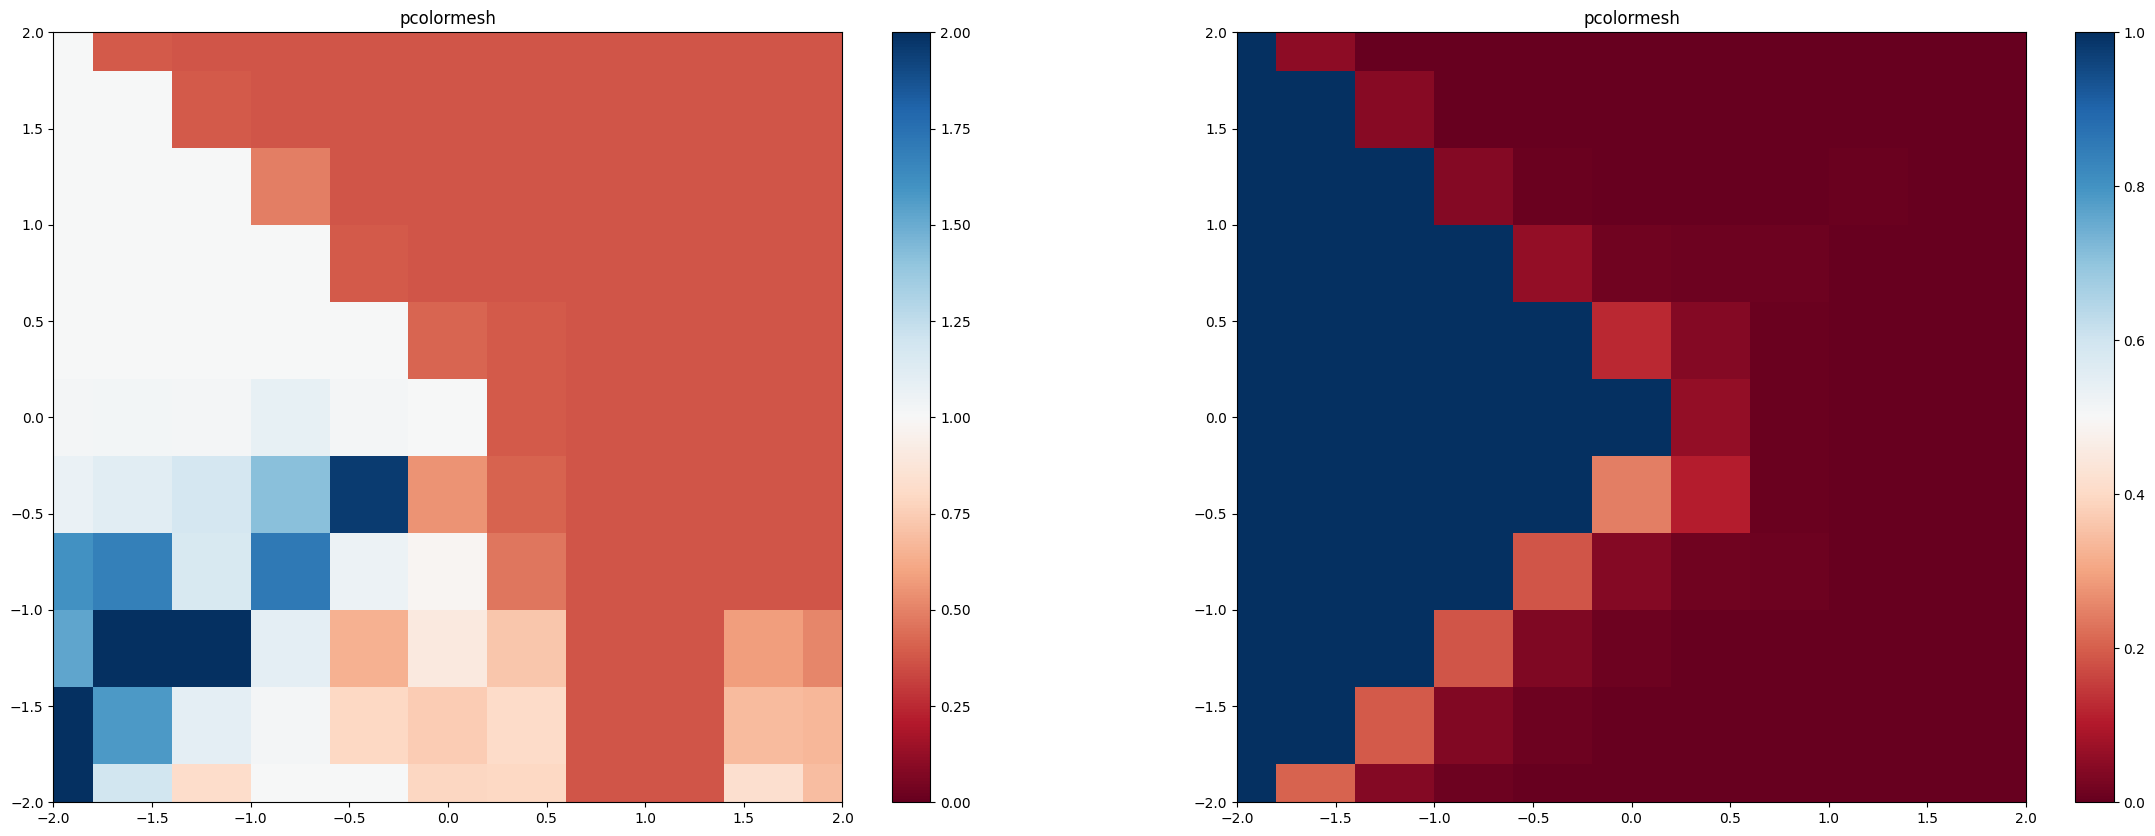

In [225]:
h = 0.5
T = 0.25
L = 10

df = df_final[(df_final.temperature == T)&(df_final.n_sites == L)]

Jx_list = df.Jx.unique()
Jy_list = df.Jy.unique()
Jz_list = df.Jz.unique()
Jy_list = df.Jy.unique()
hx_list = df.hx.unique()
hz_list = df.hz.unique()

z = []
z2 = []
df = df[df.hx == h]
x, y = np.meshgrid(Jx_list, Jy_list)
for Jx, Jy in zip(x.reshape(-1), y.reshape(-1)):
    df_plot = df[df.hx == h]
    df_plot = df_plot[(df_plot.Jx==Jx) & (df_plot.Jy==Jy)]
    df_plot = get_loss(df_plot)
    df_u = df_plot[~df_plot.loss.isna()]
    df_h = df_plot[df_plot.loss.isna()]
    au = df_u["as"].mean()
    ah = df_h["as"].mean()
    
    z.append(np.exp(ah - au))
    z2.append(ah)
z = np.array(z).reshape(x.shape)
z2 = np.array(z2).reshape(x.shape)

fig, ax = plt.subplots(1,2,figsize=(28,10))

c = ax[0].pcolormesh(x, y, z, cmap='RdBu', vmin=0, vmax=2)
ax[0].set_title('pcolormesh')
ax[0].axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax[0])

c = ax[1].pcolormesh(x, y, z2, cmap='RdBu', vmin=0, vmax=1)
ax[1].set_title('pcolormesh')
ax[1].axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax[1])


plt.show()

In [224]:
df1 = df[df.Jx == df.Jy]
df2 = df1[df1["as"] != 1]